In [ ]:
import matplotlib.pyplot as plt
from scipy.io import wavfile
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
from math import ceil
import gpuRIR

gpuRIR.activateMixedPrecision(False)

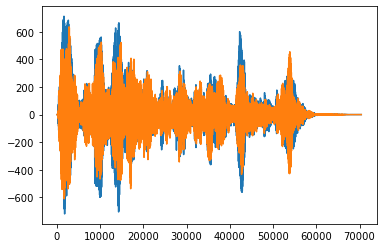

In [8]:
fs, source_signal = wavfile.read('assets/clean.wav')
source_signal = source_signal[..., 0]

room_sz = [3,4,2.5]  # Size of the room [m]
traj_pts = 64  # Number of trajectory points
pos_traj = np.tile(np.array([0.0,3.0,1.0]), (traj_pts,1))
pos_traj[:,0] = np.linspace(0.1, 2.9, traj_pts) # Positions of the trajectory points [m]
nb_rcv = 2 # Number of receivers
pos_rcv = np.array([[1.4,1,1.5],[1.6,1,1.5]])	 # Position of the receivers [m]
orV_rcv = np.array([[-1,0,0],[1,0,0]])
mic_pattern = "card" # Receiver polar pattern
T60 = 0.6 # Time for the RIR to reach 60dB of attenuation [s]
att_diff = 12.0	# Attenuation when start using the diffuse reverberation model [dB]
att_max = 40.0 # Attenuation at the end of the simulation [dB]

beta = gpuRIR.beta_SabineEstimation(room_sz, T60) # Reflection coefficients
Tdiff= gpuRIR.att2t_SabineEstimator(att_diff, T60) # Time to start the diffuse reverberation model [s]
Tmax = gpuRIR.att2t_SabineEstimator(att_max, T60)	 # Time to stop the simulation [s]
nb_img = gpuRIR.t2n( Tdiff, room_sz )	# Number of image sources in each dimension
RIRs = gpuRIR.simulateRIR(room_sz, beta, pos_traj, pos_rcv, nb_img, Tmax, fs, Tdiff=Tdiff, orV_rcv=orV_rcv, mic_pattern=mic_pattern)
filtered_signal = gpuRIR.simulateTrajectory(source_signal, RIRs)
wavfile.write('filtered_signal.wav', fs, filtered_signal)
plt.plot(filtered_signal)
plt.show()

2.0


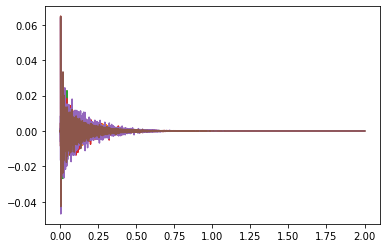

In [8]:
room_sz = [3,3,2.5]  # Size of the room [m]
nb_src = 2  # Number of sources
pos_src = np.array([[1,2.9,0.5],[1,2,0.5]]) # Positions of the sources ([m]
nb_rcv = 3 # Number of receivers
pos_rcv = np.array([[0.5,1,0.5],[1,1,0.5],[1.5,1,0.5]])	 # Position of the receivers [m]
orV_rcv = np.matlib.repmat(np.array([0,1,0]), nb_rcv, 1) # Vectors pointing in the same direction than the receivers
mic_pattern = "card" # Receiver polar pattern
abs_weights = [0.9]*5+[0.5] # Absortion coefficient ratios of the walls
T60 = 1.0	 # Time for the RIR to reach 60dB of attenuation [s]
att_diff = 15.0	# Attenuation when start using the diffuse reverberation model [dB]
att_max = 120.0 # Attenuation at the end of the simulation [dB]
fs=16000.0 # Sampling frequency [Hz]

beta = gpuRIR.beta_SabineEstimation(room_sz, T60, abs_weights=abs_weights) # Reflection coefficients
Tdiff= gpuRIR.att2t_SabineEstimator(att_diff, T60) # Time to start the diffuse reverberation model [s]
Tmax = gpuRIR.att2t_SabineEstimator(att_max, T60)	 # Time to stop the simulation [s]
print(Tmax)
nb_img = gpuRIR.t2n( Tdiff, room_sz )	# Number of image sources in each dimension
RIRs = gpuRIR.simulateRIR(room_sz, beta, pos_src, pos_rcv, nb_img, Tmax, fs, Tdiff=Tdiff, orV_rcv=orV_rcv, mic_pattern=mic_pattern)

t = np.arange(int(ceil(Tmax * fs))) / fs
plt.plot(t, RIRs.reshape(nb_src*nb_rcv, -1).transpose())
plt.show()